### Use the 100 gb ram instance

In [1]:
import pandas as pd
from tables import *
import csv
import numpy as np
import pickle
import time
from scipy import sparse
from tqdm import tqdm_notebook as tqdm

In [2]:
path = '/home/User1/data/self_citations/'

In [3]:
articles = {}
with open(path+'article.txt','r') as f:
    reader = csv.reader(f,delimiter='\t')
    next(reader)
    for line in reader:
        articles[int(line[0])] = int(line[2])

In [4]:
with open(path+'IDs_network.p','rb') as f:
    IDs_network = pickle.load(f)
authors_network = {}
count = 0
with open(path+'author_network.npy','rb') as f:
    while True:
        try:
            authors_network[IDs_network[count]] = np.load(f)
            count += 1
        except ValueError:
            break
del IDs_network

In [5]:
with open(path+'dict_citant.p','rb') as f:
    dict_citant = pickle.load(f)

In [6]:
with open(path+'dict_cluster_art.p','rb') as f:
    dict_cluster_art = pickle.load(f)

In [7]:
with open(path+'authors_disc.p','rb') as f:
    authors_disc_idx = pickle.load(f)
list_disciplines = list(authors_disc_idx.keys())
nb_disciplines = len(list_disciplines)

In [8]:
min_year = 1980
max_year = 2019
nb_years = max_year-min_year

In [9]:
authors_info = {}
with open(path+'authors_info.csv','r') as f:
    reader = csv.reader(f,delimiter='\t')
    next(reader)
    for line in reader:
        authors_info[int(line[0])] = [line[1],int(line[2])]

In [13]:
citants = list(dict_citant.keys())
nb_citants = len(citants)
idx = np.arange(nb_citants)
np.random.shuffle(idx)
types_cit = ['self']
nb_types = len(types_cit)
total_iterations = nb_citants*nb_types

### Compute year normalized citations

In [11]:
citant_per_year = np.zeros(nb_years)
ref_per_year = np.zeros(nb_years)
for i in tqdm(range(nb_citants)):
    art_citant = citants[idx[i]]
    year_citant = articles[art_citant]
    if year_citant >= min_year and year_citant < max_year:
        rel_year_citant = year_citant - min_year
        citant_per_year[rel_year_citant] += 1
        ref_per_year[rel_year_citant] += len(dict_citant[art_citant])
cit_per_art_year = np.divide(ref_per_year,citant_per_year)

/home/User1/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  This is separate from the ipykernel package so we can avoid doing imports until


A Jupyter Widget

In [12]:
weight_citant = 1/(cit_per_art_year/max(cit_per_art_year))
weight_citant = {year:weight_citant[i] for i,year in enumerate(range(min_year,max_year))}

In [ ]:
f = open(path+'progress.txt','w')
count = 0
start_time = time.time()
for type_cit in types_cit:
    rm_time = time.time()
    references = {d:sparse.lil_matrix((len(authors_disc_idx[d]),nb_years)) for d in list_disciplines}
    citations = {d:sparse.lil_matrix((len(authors_disc_idx[d]),nb_years)) for d in list_disciplines}
    start_time = start_time + time.time() - rm_time
    for i in range(nb_citants):
        count += 1
        art_citant = citants[idx[i]]
        year_citant = articles[art_citant]
        if year_citant >= min_year and year_citant < max_year:
            weight = weight_citant[year_citant]
            if art_citant in dict_cluster_art:
                authors_citant = set(dict_cluster_art[art_citant])
                networks_citant = {}
                full_network_citant = set()
                for ID_author_citant in authors_citant:
                    if ID_author_citant in authors_network:
                        network = authors_network[ID_author_citant]
                        idx_net = np.where(network[1,:]<=year_citant)[0]
                        network = set(network[0,idx_net])
                        networks_citant[ID_author_citant] = network
                        full_network_citant.update(network)
                refs_citant = set(dict_citant[art_citant])
                for ref in refs_citant:
                    if ref in dict_cluster_art:
                        authors_cite = set(dict_cluster_art[ref])
                        int_authors = authors_cite.intersection(authors_citant)
                        if len(int_authors) == 0:
                            networks_cite = {}
                            full_network_cite = set()
                            for ID_author_cite in authors_cite:
                                if ID_author_cite in authors_network:
                                    network = authors_network[ID_author_cite]
                                    idx_net = np.where(network[1,:]<=year_citant)[0]
                                    network = set(network[0,idx_net])
                                    networks_cite[ID_author_cite] = network
                                    full_network_cite.update(network)

                            for ID_author_cite in authors_cite:
                                if ID_author_cite in authors_network:
                                    if len(authors_citant.intersection(networks_cite[ID_author_cite])) > 0:
                                        if type_cit == 'self':
                                            info = authors_info[ID_author_cite]
                                            author_age = year_citant - info[1]
                                            if author_age < nb_years:
                                                disc = info[0]
                                                author_idx = authors_disc_idx[disc][ID_author_cite]
                                                citations[disc][author_idx,author_age] += weight
                                    else:
                                        if type_cit == 'co':
                                            if len(authors_citant.intersection(full_network_cite)) > 0:
                                                info = authors_info[ID_author_cite]
                                                author_age = year_citant - info[1]
                                                if author_age < 0:
                                                    author_age = 0
                                                if author_age < nb_years:
                                                    disc = info[0]
                                                    author_idx = authors_disc_idx[disc][ID_author_cite]
                                                    citations[disc][author_idx,author_age] += weight

                            for ID_author_citant in authors_citant:
                                if ID_author_citant in authors_network:
                                    if len(authors_citant.intersection(networks_citant[ID_author_citant])) > 0:
                                        if type_cit == 'self':
                                            info = authors_info[ID_author_citant]
                                            author_age = year_citant - info[1]
                                            if author_age < nb_years:
                                                disc = info[0]
                                                author_idx = authors_disc_idx[disc][ID_author_citant]
                                                references[disc][author_idx,author_age] += weight
                                    else:
                                        if type_cit == 'co':
                                            if len(authors_citant.intersection(full_network_citant)) > 0:
                                                info = authors_info[ID_author_citant]
                                                author_age = year_citant - info[1]
                                                if author_age < nb_years:
                                                    disc = info[0]
                                                    author_idx = authors_disc_idx[disc][ID_author_citant]
                                                    references[disc][author_idx,author_age] += weight                                    
        if count % 1000 == 1 :
            elapsed_time = time.time() - start_time
            elapsed_time_h = np.round(elapsed_time/3600,2)
            time_per_art = elapsed_time/count
            time_left_h = np.round(time_per_art*(total_iterations-count)/3600,2)
            perc = np.round(count/total_iterations*100,3)
            f.write('Progress: {} articles, {}%, Time since start: {}, Time left: {}\n'.format(count,perc,elapsed_time_h,time_left_h))    
            f.flush()
    for disc in list_disciplines:
        with open('{}/arrays/citations_{}_{}_network_array_norm.npz'.format(path,type_cit,disc),'wb') as f2:
            sparse.save_npz(f2,sparse.csr_matrix(citations[disc]))
        with open('{}/arrays/references_{}_{}_network_array_norm.npz'.format(path,type_cit,disc),'wb') as f2:
            sparse.save_npz(f2,sparse.csr_matrix(references[disc]))

### Direct only

In [18]:
from matplotlib import pyplot as plt


In [51]:
art_id = np.array(art_id)

In [52]:
arts_high = art_id[np.where(np.array(dist_time)>10)[0]]

In [53]:
np.where(np.array(dist_time)>10)[0]

array([  736,   737,  4771,  7105, 10992, 11249, 14739, 16828])

In [86]:
art_citant = arts_high[3]

In [87]:
authors_citant = dict_cluster_art[art_citant]

In [88]:
authors_citant 

array([33043831], dtype=uint32)

In [89]:
len(authors_citant)

1

In [90]:
refs_citant = dict_citant[art_citant]

In [91]:
refs_citant

array([ 1884292,  2624172,  3744580,  4271313,  5206318,  5076034,
        5371890,  9098587,  9971583, 10802197, 11027436, 11363399,
       11230150, 13633345, 13996668, 14630182, 14793791, 15614376,
       18046573, 19282165, 19446895, 19589280, 19675353, 19787635,
       20216102, 20916387, 21057480, 21987619, 21933743, 23124596,
       23173549, 23515792, 23502518, 23640748, 23649397, 23983719,
       24160352, 24439789, 24518090, 24547714, 24526251, 25123639,
       25417575, 25463071, 26220632, 26231363, 26274843, 26257774,
       26584995, 26952145, 27277866, 27821210, 28183973, 29223183,
       29244559, 29344082, 29594216, 30586891, 30887476, 31369021,
       31415801, 32312594, 32535329, 32694982, 32820804, 37028590,
       37698784, 39980493, 44735802, 45018750, 45196133, 45963098,
       46438588, 46473056, 47236060, 47513168, 47563193, 47655414,
       48220163, 48359925, 48483427, 48507790, 48536314, 48555241,
       48813032, 49372528, 49731444, 49953391, 49979679, 50502

In [83]:
def prof_lines():
    year_citant = articles[art_citant]
    if year_citant >= min_year and year_citant < max_year:
        art_start = time.time()

        weight = weight_citant[year_citant]
        if art_citant in dict_cluster_art:
            authors_citant = set(dict_cluster_art[art_citant])
            networks_citant = {}
            for ID_author_citant in authors_citant:
                if ID_author_citant in authors_network:
                    network = authors_network[ID_author_citant]
                    idx_net = np.where(network[1,:]<=year_citant)[0]
                    network = set(network[0,idx_net])
                    networks_citant[ID_author_citant] = network

            refs_citant = set(dict_citant[art_citant])
            for ref in refs_citant:
                if ref in dict_cluster_art:
                    authors_cite = set(dict_cluster_art[ref])
                    int_authors = authors_cite.intersection(authors_citant)
                    if len(int_authors) == 0:
                        networks_cite = {}
                        for ID_author_cite in authors_cite:
                            if ID_author_cite in authors_network:
                                network = authors_network[ID_author_cite]
                                idx_net = np.where(network[1,:]<=year_citant)[0]
                                network = set(network[0,idx_net])
                                networks_cite[ID_author_cite] = network

                        for ID_author_cite in authors_cite:
                            if ID_author_cite in authors_network:
                                if len(authors_citant.intersection(networks_cite[ID_author_cite])) > 0:
                                    if type_cit == 'self':
                                        info = authors_info[ID_author_cite]
                                        author_age = year_citant - info[1]
                                        if author_age < nb_years:
                                            disc = info[0]
                                            author_idx = authors_disc_idx[disc][ID_author_cite]
                                            citations[disc][author_idx,author_age] += weight

                        for ID_author_citant in authors_citant:
                            if ID_author_citant in authors_network:
                                if len(authors_citant.intersection(networks_citant[ID_author_citant])) > 0:
                                    if type_cit == 'self':
                                        info = authors_info[ID_author_citant]
                                        author_age = year_citant - info[1]
                                        if author_age < nb_years:
                                            disc = info[0]
                                            author_idx = authors_disc_idx[disc][ID_author_citant]
                                            references[disc][author_idx,author_age] += weight

In [92]:
%lprun -f prof_lines prof_lines()

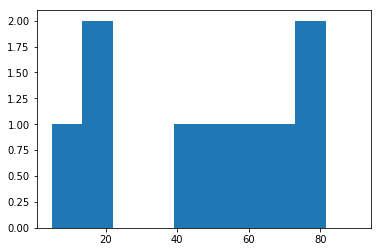

In [45]:
plt.hist(dist_time,bins=10,range=(5,90))
plt.show()

In [43]:
dist_time = []
art_id = []

### With max 

In [93]:
max_net = 1500
max_aut = 1500

In [94]:
for key in authors_network:
    if len(authors_network[key]) > max_net:
        del authors_network[key]

In [ ]:
f = open(path+'progress.txt','w')
count = 0
start_time = time.time()
for type_cit in types_cit:
    rm_time = time.time()
    references = {d:sparse.lil_matrix((len(authors_disc_idx[d]),nb_years)) for d in list_disciplines}
    citations = {d:sparse.lil_matrix((len(authors_disc_idx[d]),nb_years)) for d in list_disciplines}
    start_time = start_time + time.time() - rm_time
    for i in range(nb_citants):
        count += 1
        art_citant = citants[idx[i]]
        year_citant = articles[art_citant]
        if year_citant >= min_year and year_citant < max_year:
            art_start = time.time()
            weight = weight_citant[year_citant]
            if art_citant in dict_cluster_art:
                authors_citant = set(dict_cluster_art[art_citant])
                if len(authors_citant) < max_aut:
                    networks_citant = {}
                    for ID_author_citant in authors_citant:
                        if ID_author_citant in authors_network:
                            network = authors_network[ID_author_citant]
                            idx_net = np.where(network[1,:]<=year_citant)[0]
                            network = set(network[0,idx_net])
                            networks_citant[ID_author_citant] = network

                    refs_citant = set(dict_citant[art_citant])
                    for ref in refs_citant:
                        if ref in dict_cluster_art:
                            authors_cite = set(dict_cluster_art[ref])
                            int_authors = authors_cite.intersection(authors_citant)
                            if len(int_authors) == 0:
                                networks_cite = {}
                                for ID_author_cite in authors_cite:
                                    if ID_author_cite in authors_network:
                                        network = authors_network[ID_author_cite]
                                        idx_net = np.where(network[1,:]<=year_citant)[0]
                                        network = set(network[0,idx_net])
                                        networks_cite[ID_author_cite] = network

                                for ID_author_cite in authors_cite:
                                    if ID_author_cite in authors_network:
                                        if len(authors_citant.intersection(networks_cite[ID_author_cite])) > 0:
                                            if type_cit == 'self':
                                                info = authors_info[ID_author_cite]
                                                author_age = year_citant - info[1]
                                                if author_age < nb_years:
                                                    disc = info[0]
                                                    author_idx = authors_disc_idx[disc][ID_author_cite]
                                                    citations[disc][author_idx,author_age] += weight

                                for ID_author_citant in authors_citant:
                                    if ID_author_citant in authors_network:
                                        if len(authors_citant.intersection(networks_citant[ID_author_citant])) > 0:
                                            if type_cit == 'self':
                                                info = authors_info[ID_author_citant]
                                                author_age = year_citant - info[1]
                                                if author_age < nb_years:
                                                    disc = info[0]
                                                    author_idx = authors_disc_idx[disc][ID_author_citant]
                                                    references[disc][author_idx,author_age] += weight
            #dist_time.append(time.time()-art_start)
            #art_id.append(art_citant)                                                     
        if count % 1000 == 1 :
            elapsed_time = time.time() - start_time
            elapsed_time_h = np.round(elapsed_time/3600,2)
            time_per_art = elapsed_time/count
            time_left_h = np.round(time_per_art*(total_iterations-count)/3600,2)
            perc = np.round(count/total_iterations*100,3)
            f.write('Progress: {} articles, {}%, Time since start: {}, Time left: {}\n'.format(count,perc,elapsed_time_h,time_left_h))    
            f.flush()
    for disc in list_disciplines:
        with open('{}/arrays/citations_{}_{}_network_array_norm.npz'.format(path,type_cit,disc),'wb') as f2:
            sparse.save_npz(f2,sparse.csr_matrix(citations[disc]))
        with open('{}/arrays/references_{}_{}_network_array_norm.npz'.format(path,type_cit,disc),'wb') as f2:
            sparse.save_npz(f2,sparse.csr_matrix(references[disc]))

### Author based

In [ ]:
f = open(path+'progress.txt','w')
count = 0
start_time = time.time()

for type_cit in types_cit:
    rm_time = time.time()
    references = {d:sparse.lil_matrix((len(authors_disc_idx[d]),nb_years)) for d in list_disciplines}
    citations = {d:sparse.lil_matrix((len(authors_disc_idx[d]),nb_years)) for d in list_disciplines}
    start_time = start_time + time.time() - rm_time
    for i in range(nb_authors):
    
    for i in range(nb_citants):
        count += 1
        art_citant = citants[idx[i]]
        year_citant = articles[art_citant]
        if year_citant >= min_year and year_citant < max_year:
            art_start = time.time()
            weight = weight_citant[year_citant]
            if art_citant in dict_cluster_art:
                authors_citant = set(dict_cluster_art[art_citant])
                if len(authors_citant) < max_aut:
                    networks_citant = {}
                    for ID_author_citant in authors_citant:
                        if ID_author_citant in authors_network:
                            network = authors_network[ID_author_citant]
                            idx_net = np.where(network[1,:]<=year_citant)[0]
                            network = set(network[0,idx_net])
                            networks_citant[ID_author_citant] = network

                    refs_citant = set(dict_citant[art_citant])
                    for ref in refs_citant:
                        if ref in dict_cluster_art:
                            authors_cite = set(dict_cluster_art[ref])
                            int_authors = authors_cite.intersection(authors_citant)
                            if len(int_authors) == 0:
                                networks_cite = {}
                                for ID_author_cite in authors_cite:
                                    if ID_author_cite in authors_network:
                                        network = authors_network[ID_author_cite]
                                        idx_net = np.where(network[1,:]<=year_citant)[0]
                                        network = set(network[0,idx_net])
                                        networks_cite[ID_author_cite] = network

                                for ID_author_cite in authors_cite:
                                    if ID_author_cite in authors_network:
                                        if len(authors_citant.intersection(networks_cite[ID_author_cite])) > 0:
                                            if type_cit == 'self':
                                                info = authors_info[ID_author_cite]
                                                author_age = year_citant - info[1]
                                                if author_age < nb_years:
                                                    disc = info[0]
                                                    author_idx = authors_disc_idx[disc][ID_author_cite]
                                                    citations[disc][author_idx,author_age] += weight

                                for ID_author_citant in authors_citant:
                                    if ID_author_citant in authors_network:
                                        if len(authors_citant.intersection(networks_citant[ID_author_citant])) > 0:
                                            if type_cit == 'self':
                                                info = authors_info[ID_author_citant]
                                                author_age = year_citant - info[1]
                                                if author_age < nb_years:
                                                    disc = info[0]
                                                    author_idx = authors_disc_idx[disc][ID_author_citant]
                                                    references[disc][author_idx,author_age] += weight
            #dist_time.append(time.time()-art_start)
            #art_id.append(art_citant)                                                     
        if count % 1000 == 1 :
            elapsed_time = time.time() - start_time
            elapsed_time_h = np.round(elapsed_time/3600,2)
            time_per_art = elapsed_time/count
            time_left_h = np.round(time_per_art*(total_iterations-count)/3600,2)
            perc = np.round(count/total_iterations*100,3)
            f.write('Progress: {} articles, {}%, Time since start: {}, Time left: {}\n'.format(count,perc,elapsed_time_h,time_left_h))    
            f.flush()
    for disc in list_disciplines:
        with open('{}/arrays/citations_{}_{}_network_array_norm.npz'.format(path,type_cit,disc),'wb') as f2:
            sparse.save_npz(f2,sparse.csr_matrix(citations[disc]))
        with open('{}/arrays/references_{}_{}_network_array_norm.npz'.format(path,type_cit,disc),'wb') as f2:
            sparse.save_npz(f2,sparse.csr_matrix(references[disc]))

### Direct cits

In [44]:
f = open(path+'progress.txt','w')
count = 0
start_time = time.time()
for type_cit in types_cit:
    rm_time = time.time()
    references = {d:sparse.lil_matrix((len(authors_disc_idx[d]),nb_years)) for d in list_disciplines}
    citations = {d:sparse.lil_matrix((len(authors_disc_idx[d]),nb_years)) for d in list_disciplines}
    start_time = start_time + time.time() - rm_time
    for i in range(nb_citants):
        count += 1
        art_citant = citants[idx[i]]
        year_citant = articles[art_citant]
        if year_citant >= min_year and year_citant < max_year:
            art_start = time.time()
            
            weight = weight_citant[year_citant]
            if art_citant in dict_cluster_art:
                authors_citant = set(dict_cluster_art[art_citant])
                if len(authors_citant) < max_citant:
                    networks_citant = {}
                    for ID_author_citant in authors_citant:
                        if ID_author_citant in authors_network:
                            network = authors_network[ID_author_citant]
                            idx_net = np.where(network[1,:]<=year_citant)[0]
                            network = set(network[0,idx_net])
                            networks_citant[ID_author_citant] = network

                    refs_citant = set(dict_citant[art_citant])
                    for ref in refs_citant:
                        if ref in dict_cluster_art:
                            authors_cite = set(dict_cluster_art[ref])
                            int_authors = authors_cite.intersection(authors_citant)
                            if len(int_authors) == 0:
                                networks_cite = {}
                                for ID_author_cite in authors_cite:
                                    if ID_author_cite in authors_network:
                                        network = authors_network[ID_author_cite]
                                        idx_net = np.where(network[1,:]<=year_citant)[0]
                                        network = set(network[0,idx_net])
                                        networks_cite[ID_author_cite] = network

                                for ID_author_cite in authors_cite:
                                    if ID_author_cite in authors_network:
                                        if len(authors_citant.intersection(networks_cite[ID_author_cite])) > 0:
                                            if type_cit == 'self':
                                                info = authors_info[ID_author_cite]
                                                author_age = year_citant - info[1]
                                                if author_age < nb_years:
                                                    disc = info[0]
                                                    author_idx = authors_disc_idx[disc][ID_author_cite]
                                                    citations[disc][author_idx,author_age] += weight

                                for ID_author_citant in authors_citant:
                                    if ID_author_citant in authors_network:
                                        if len(authors_citant.intersection(networks_citant[ID_author_citant])) > 0:
                                            if type_cit == 'self':
                                                info = authors_info[ID_author_citant]
                                                author_age = year_citant - info[1]
                                                if author_age < nb_years:
                                                    disc = info[0]
                                                    author_idx = authors_disc_idx[disc][ID_author_citant]
                                                    references[disc][author_idx,author_age] += weight
            #dist_time.append(time.time()-art_start)
            #art_id.append(art_citant)                                                     
        if count % 1000 == 1 :
            elapsed_time = time.time() - start_time
            elapsed_time_h = np.round(elapsed_time/3600,2)
            time_per_art = elapsed_time/count
            time_left_h = np.round(time_per_art*(total_iterations-count)/3600,2)
            perc = np.round(count/total_iterations*100,3)
            f.write('Progress: {} articles, {}%, Time since start: {}, Time left: {}\n'.format(count,perc,elapsed_time_h,time_left_h))    
            f.flush()
    for disc in list_disciplines:
        with open('{}/arrays/citations_{}_{}_network_array_norm.npz'.format(path,type_cit,disc),'wb') as f2:
            sparse.save_npz(f2,sparse.csr_matrix(citations[disc]))
        with open('{}/arrays/references_{}_{}_network_array_norm.npz'.format(path,type_cit,disc),'wb') as f2:
            sparse.save_npz(f2,sparse.csr_matrix(references[disc]))

KeyboardInterrupt: 

In [14]:
%load_ext cython

### cython

In [21]:
%load_ext Cython

In [25]:
%%cython
import numpy as np

import time
from scipy import sparse

def computeOverlap(set testSet, set targetSets):
    cdef list obsOverlaps  = []
    cdef int i, N
    cdef set overlap
    N = len(targetSets)
    for i in range(N):
        overlap = testSet & targetSets[i]
        if len(overlap) <= 1:
            obsOverlaps.append(0)
        else:
            obsOverlaps.append(len(overlap))
    return obsOverlaps

def create_network(path,types_cit,authors_disc_idx,authors_info,list list_disciplines,dict_citant,articles,
                  int min_year,int max_year,int nb_years,weight_citant,dict_cluster_art,authors_network):
    
    citants = list(dict_citant.keys())
    nb_citants = len(citants)
    idx = np.arange(nb_citants)
    np.random.shuffle(idx)
    types_cit = ['co','self']
    nb_types = len(types_cit)
    total_iterations = nb_citants*nb_types
    
    f = open(path+'progress.txt','w')
    count = 0
    start_time = time.time()
    for type_cit in types_cit:
        rm_time = time.time()
        references = {d:sparse.lil_matrix((len(authors_disc_idx[d]),nb_years)) for d in list_disciplines}
        citations = {d:sparse.lil_matrix((len(authors_disc_idx[d]),nb_years)) for d in list_disciplines}
        start_time = start_time + time.time() - rm_time
        for i in range(nb_citants):
            count += 1
            art_citant = citants[idx[i]]
            year_citant = articles[art_citant]
            if year_citant >= min_year and year_citant < max_year:
                weight = weight_citant[year_citant]
                if art_citant in dict_cluster_art:
                    authors_citant = set(dict_cluster_art[art_citant])
                    networks_citant = {}
                    full_network_citant = set()
                    for ID_author_citant in authors_citant:
                        if ID_author_citant in authors_network:
                            network = authors_network[ID_author_citant]
                            idx_net = np.where(network[1,:]<=year_citant)[0]
                            network = set(network[0,idx_net])
                            networks_citant[ID_author_citant] = network
                            full_network_citant = full_network_citant|network
                    refs_citant = set(dict_citant[art_citant])
                    for ref in refs_citant:
                        if ref in dict_cluster_art:
                            authors_cite = set(dict_cluster_art[ref])
                            int_authors = authors_cite.intersection(authors_citant)
                            if len(int_authors) == 0:
                                networks_cite = {}
                                full_network_cite = set()
                                for ID_author_cite in authors_cite:
                                    if ID_author_cite in authors_network:
                                        network = authors_network[ID_author_cite]
                                        idx_net = np.where(network[1,:]<=year_citant)[0]
                                        network = set(network[0,idx_net])
                                        networks_cite[ID_author_cite] = network
                                        full_network_cite = full_network_cite|network

                                for ID_author_cite in authors_cite:
                                    if ID_author_cite in authors_network:
                                        if len(authors_citant.intersection(networks_cite[ID_author_cite])) > 0:
                                            if type_cit == 'self':
                                                info = authors_info[ID_author_cite]
                                                author_age = year_citant - info[1]
                                                if author_age < nb_years:
                                                    disc = info[0]
                                                    author_idx = authors_disc_idx[disc][ID_author_cite]
                                                    citations[disc][author_idx,author_age] += weight
                                        else:
                                            if type_cit == 'co':
                                                if len(authors_citant.intersection(full_network_cite)) > 0:
                                                    info = authors_info[ID_author_cite]
                                                    author_age = year_citant - info[1]
                                                    if author_age < 0:
                                                        author_age = 0
                                                    if author_age < nb_years:
                                                        disc = info[0]
                                                        author_idx = authors_disc_idx[disc][ID_author_cite]
                                                        citations[disc][author_idx,author_age] += weight

                                for ID_author_citant in authors_citant:
                                    if ID_author_citant in authors_network:
                                        if len(authors_citant.intersection(networks_citant[ID_author_citant])) > 0:
                                            if type_cit == 'self':
                                                info = authors_info[ID_author_citant]
                                                author_age = year_citant - info[1]
                                                if author_age < nb_years:
                                                    disc = info[0]
                                                    author_idx = authors_disc_idx[disc][ID_author_citant]
                                                    references[disc][author_idx,author_age] += weight
                                        else:
                                            if type_cit == 'co':
                                                if len(authors_citant.intersection(full_network_citant)) > 0:
                                                    info = authors_info[ID_author_citant]
                                                    author_age = year_citant - info[1]
                                                    if author_age < nb_years:
                                                        disc = info[0]
                                                        author_idx = authors_disc_idx[disc][ID_author_citant]
                                                        references[disc][author_idx,author_age] += weight                                    
            if count % 1000 == 1 :
                elapsed_time = time.time() - start_time
                elapsed_time_h = np.round(elapsed_time/3600,2)
                time_per_art = elapsed_time/count
                time_left_h = np.round(time_per_art*(total_iterations-count)/3600,2)
                perc = np.round(count/total_iterations*100,3)
                f.write('Progress: {} articles, {}%, Time since start: {}, Time left: {}\n'.format(count,perc,elapsed_time_h,time_left_h))    
                f.flush()
        for disc in list_disciplines:
            with open('{}/arrays/citations_{}_{}_network_array_norm.npz'.format(path,type_cit,disc),'wb') as f2:
                sparse.save_npz(f2,sparse.csr_matrix(citations[disc]))
            with open('{}/arrays/references_{}_{}_network_array_norm.npz'.format(path,type_cit,disc),'wb') as f2:
                sparse.save_npz(f2,sparse.csr_matrix(references[disc]))

OSError: [Errno 12] Cannot allocate memory

In [24]:
references = {d:sparse.lil_matrix((len(authors_disc_idx[d]),nb_years)) for d in list_disciplines}
citations = {d:sparse.lil_matrix((len(authors_disc_idx[d]),nb_years)) for d in list_disciplines}

In [26]:
def prof_lines():
    count = 0
    for i in range(200):#range(nb_citants):
        count += 1
        art_citant = citants[idx[i]]
        year_citant = articles[art_citant]
        if year_citant >= min_year and year_citant < max_year:
            weight = weight_citant[year_citant]
            if art_citant in dict_cluster_art:
                authors_citant = dict_cluster_art[art_citant]
                networks_citant = {}
                full_network_citant = np.array([])
                for ID_author_citant in authors_citant:
                    if ID_author_citant in authors_network:
                        network = authors_network[ID_author_citant]
                        idx_net = np.where(network[1,:]<=year_citant)[0]
                        network = network[0,idx_net]
                        networks_citant[ID_author_citant] = network
                        full_network_citant = np.append(full_network_citant,network)
                refs_citant = set(dict_citant[art_citant])
                for ref in refs_citant:
                    if ref in dict_cluster_art:
                        authors_cite = set(dict_cluster_art[ref])
                        int_authors = authors_cite.intersection(authors_citant)
                        if len(int_authors) == 0:
                            networks_cite = {}
                            full_network_cite = np.array([])
                            for ID_author_cite in authors_cite:
                                if ID_author_cite in authors_network:
                                    network = authors_network[ID_author_cite]
                                    idx_net = np.where(network[1,:]<=year_citant)[0]
                                    network = network[0,idx_net]
                                    networks_cite[ID_author_cite] = network
                                    full_network_cite = np.append(full_network_cite,network)

                            for ID_author_cite in authors_cite:
                                if ID_author_cite in authors_network:
                                    #if np.sum(authors_citant.isin(networks_cite[ID_author_cite])) > 0:
                                    if len(np.intersect1d(authors_citant,networks_cite[ID_author_cite])) > 0:
                                        if type_cit == 'self':
                                            info = authors_info[ID_author_cite]
                                            author_age = year_citant - info[1]
                                            if author_age < nb_years:
                                                disc = info[0]
                                                author_idx = authors_disc_idx[disc][ID_author_cite]
                                                citations[disc][author_idx,author_age] += weight
                                    else:
                                        if type_cit == 'co':
                                            if len(np.intersect1d(authors_citant,full_network_cite)) > 0:
                                            #if np.sum(authors_citant.isin(full_network_cite)) > 0:
                                                info = authors_info[ID_author_cite]
                                                author_age = year_citant - info[1]
                                                if author_age < 0:
                                                    author_age = 0
                                                if author_age < nb_years:
                                                    disc = info[0]
                                                    author_idx = authors_disc_idx[disc][ID_author_cite]
                                                    citations[disc][author_idx,author_age] += weight

                            for ID_author_citant in authors_citant:
                                if ID_author_citant in authors_network:
                                    if len(np.intersect1d(authors_citant,networks_citant[ID_author_citant])) > 0:
                                        if type_cit == 'self':
                                            info = authors_info[ID_author_citant]
                                            author_age = year_citant - info[1]
                                            if author_age < nb_years:
                                                disc = info[0]
                                                author_idx = authors_disc_idx[disc][ID_author_citant]
                                                references[disc][author_idx,author_age] += weight
                                    else:
                                        if type_cit == 'co':
                                            if len(np.intersect1d(authors_citant,full_network_citant)) > 0:
                                                info = authors_info[ID_author_citant]
                                                author_age = year_citant - info[1]
                                                if author_age < nb_years:
                                                    disc = info[0]
                                                    author_idx = authors_disc_idx[disc][ID_author_citant]
                                                    references[disc][author_idx,author_age] += weight

In [31]:
%%cython
def computeOverlap(set testSet, set targetSets):
    cdef list obsOverlaps  = []
    cdef int i, N
    cdef set overlap
    N = len(targetSets)
    for i in range(N):
        overlap = testSet & targetSets[i]
        if len(overlap) <= 1:
            obsOverlaps.append(0)
        else:
            obsOverlaps.append(len(overlap))
    return obsOverlaps

OSError: [Errno 12] Cannot allocate memory

In [32]:
import os
pid = os.fork()

OSError: [Errno 12] Cannot allocate memory

In [65]:
def prof_lines():
    count=0
    for i in range(200):#range(nb_citants):
        count += 1
        art_citant = citants[idx[i]]
        year_citant = articles[art_citant]
        if year_citant >= min_year and year_citant < max_year:
            weight = weight_citant[year_citant]
            if art_citant in dict_cluster_art:
                authors_citant = set(dict_cluster_art[art_citant])
                networks_citant = {}
                full_network_citant = set()
                for ID_author_citant in authors_citant:
                    if ID_author_citant in authors_network:
                        network = authors_network[ID_author_citant]
                        idx_net = np.where(network[1,:]<=year_citant)[0]
                        network = set(network[0,idx_net])
                        networks_citant[ID_author_citant] = network
                        full_network_citant.update(network)
                        #full_network_citant = full_network_citant + list(network)
                #full_network_citant = set(full_network_citant)
                refs_citant = set(dict_citant[art_citant])
                for ref in refs_citant:
                    if ref in dict_cluster_art:
                        authors_cite = set(dict_cluster_art[ref])
                        int_authors = authors_cite.intersection(authors_citant)
                        if len(int_authors) == 0:
                            networks_cite = {}
                            full_network_cite = set()
                            for ID_author_cite in authors_cite:
                                if ID_author_cite in authors_network:
                                    network = authors_network[ID_author_cite]
                                    idx_net = np.where(network[1,:]<=year_citant)[0]
                                    temp = network[0,idx_net]
                                    network = set(temp)
                                    networks_cite[ID_author_cite] = network
                                    full_network_cite.update(network)
                                    #full_network_cite.extend(list(network))
                                    #full_network_cite = full_network_cite + list(network)
                            #full_network_cite = set(full_network_cite)

                            for ID_author_cite in authors_cite:
                                if ID_author_cite in authors_network:
                                    if len(authors_citant.intersection(networks_cite[ID_author_cite])) > 0:
                                        if type_cit == 'self':
                                            info = authors_info[ID_author_cite]
                                            author_age = year_citant - info[1]
                                            if author_age < nb_years:
                                                disc = info[0]
                                                author_idx = authors_disc_idx[disc][ID_author_cite]
                                                citations[disc][author_idx,author_age] += weight
                                    else:
                                        if type_cit == 'co':
                                            if len(authors_citant.intersection(full_network_cite)) > 0:
                                                info = authors_info[ID_author_cite]
                                                author_age = year_citant - info[1]
                                                if author_age < 0:
                                                    author_age = 0
                                                if author_age < nb_years:
                                                    disc = info[0]
                                                    author_idx = authors_disc_idx[disc][ID_author_cite]
                                                    citations[disc][author_idx,author_age] += weight

                            for ID_author_citant in authors_citant:
                                if ID_author_citant in authors_network:
                                    if len(authors_citant.intersection(networks_citant[ID_author_citant])) > 0:
                                        if type_cit == 'self':
                                            info = authors_info[ID_author_citant]
                                            author_age = year_citant - info[1]
                                            if author_age < nb_years:
                                                disc = info[0]
                                                author_idx = authors_disc_idx[disc][ID_author_citant]
                                                references[disc][author_idx,author_age] += weight
                                    else:
                                        if type_cit == 'co':
                                            if len(authors_citant.intersection(full_network_citant)) > 0:
                                                info = authors_info[ID_author_citant]
                                                author_age = year_citant - info[1]
                                                if author_age < nb_years:
                                                    disc = info[0]
                                                    author_idx = authors_disc_idx[disc][ID_author_citant]
                                                    references[disc][author_idx,author_age] += weight  

In [72]:
%load_ext line_profiler

In [73]:
%lprun -f prof_lines prof_lines()